In [1]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, train_final_model, plot_confusion_matrices
from model import predict
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing
## Assign labels

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()

np.int64(307)

In [4]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [5]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [6]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [7]:
categorical_unique = preprocessing.unique(df, categorical_columns)

In [8]:
numeric_unique = preprocessing.unique(df, numeric_columns)

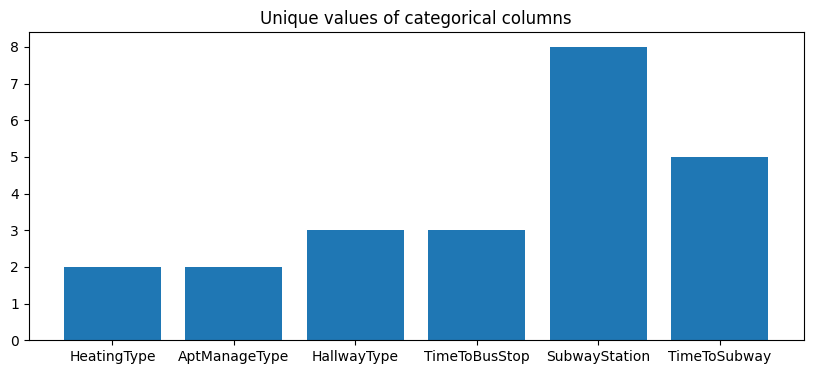

In [9]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [10]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [11]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

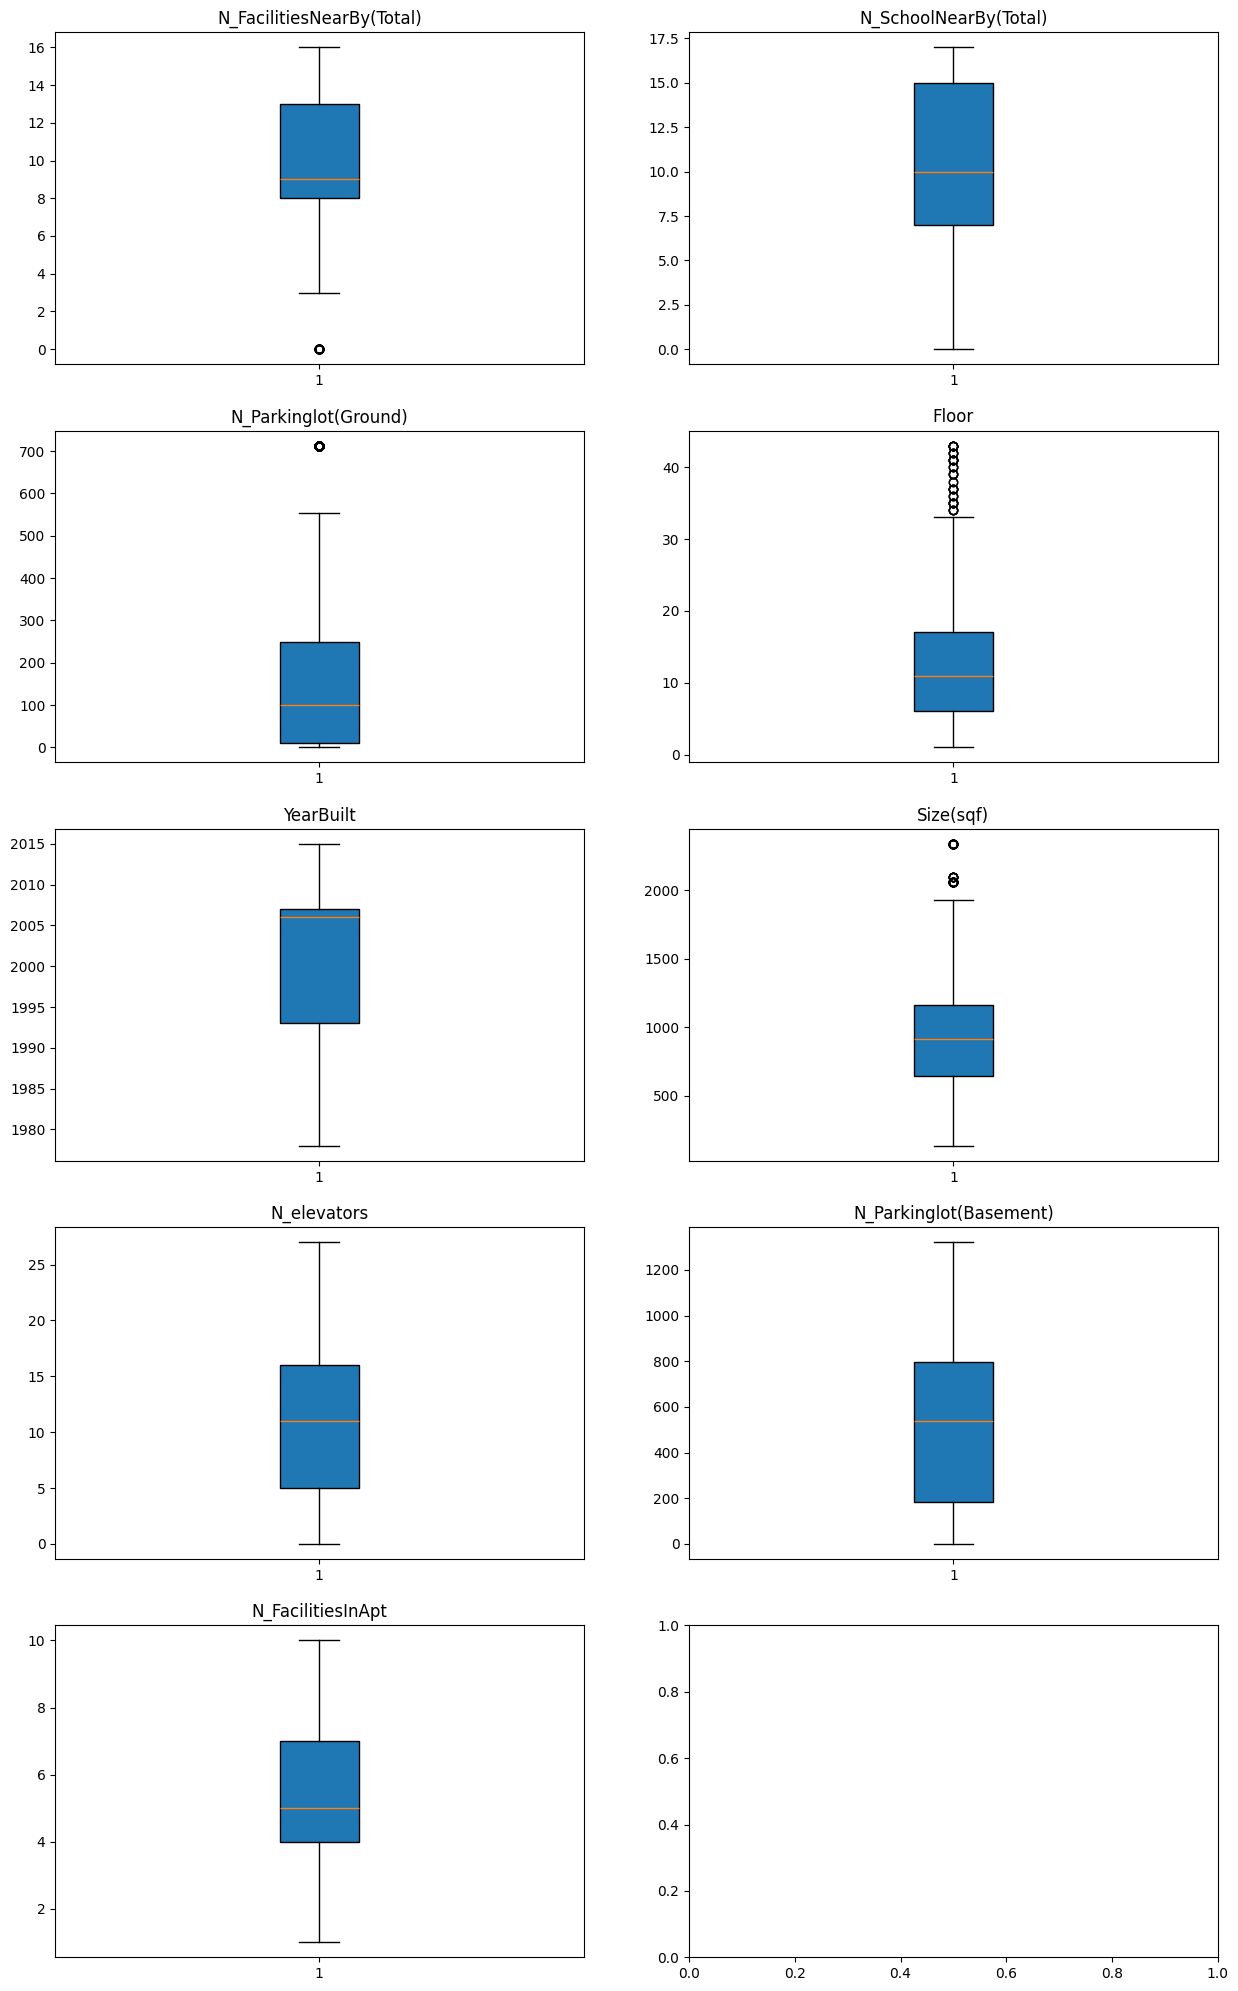

In [12]:
preprocessing.plot_boxplot(df, numeric_columns)

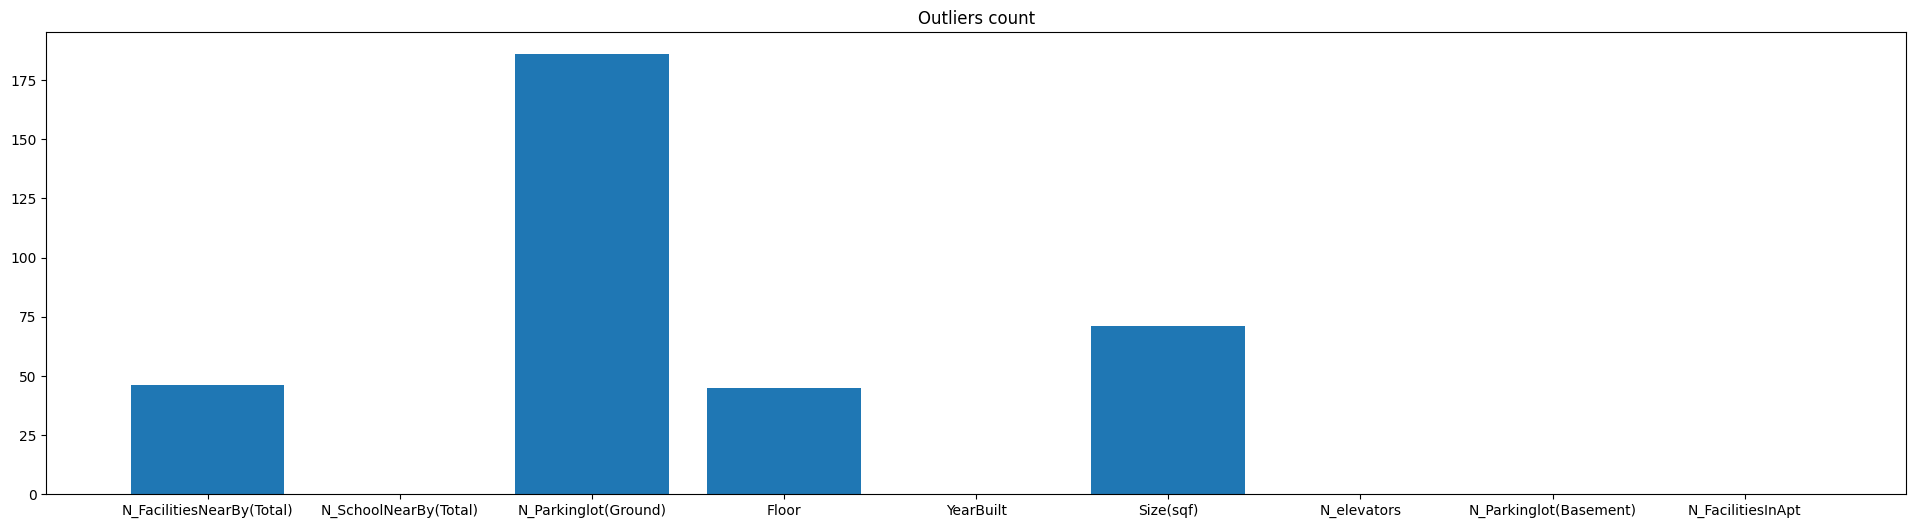

In [13]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

## Analyze if some features have normal distribution

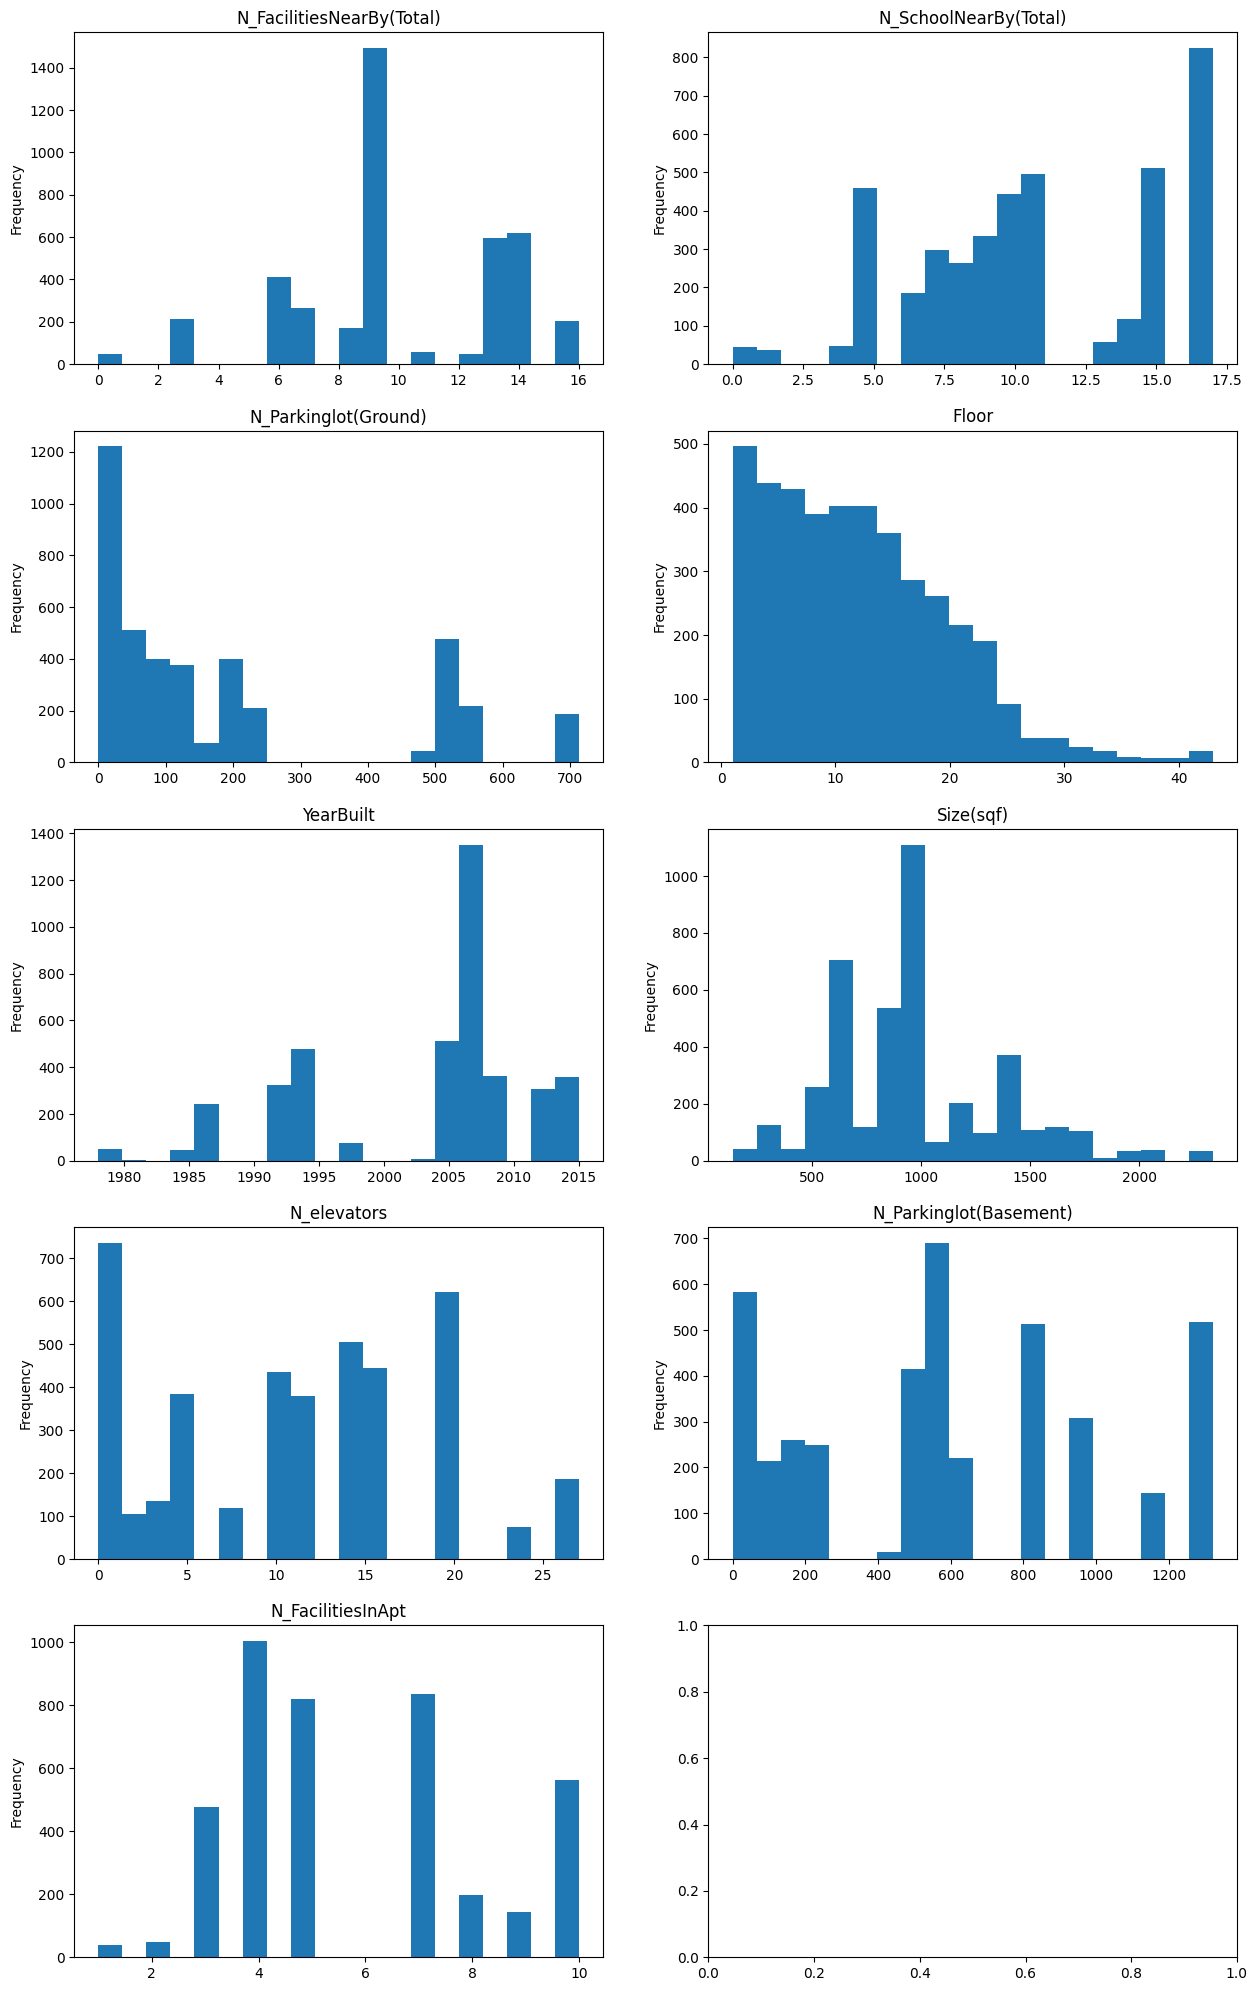

In [14]:
preprocessing.plot_histograms(df, numeric_columns)

In [15]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed',
 'Floor': 'not normally distributed',
 'YearBuilt': 'not normally distributed',
 'Size(sqf)': 'not normally distributed',
 'N_elevators': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed'}

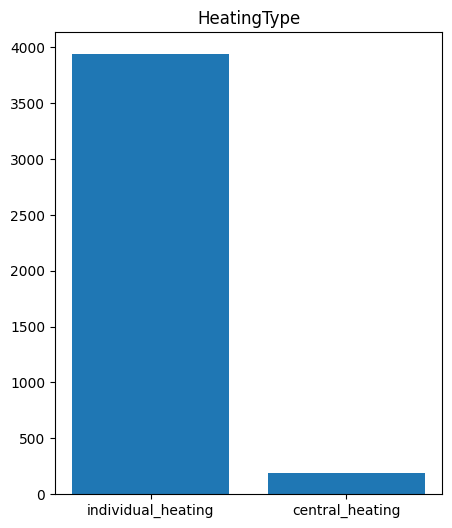

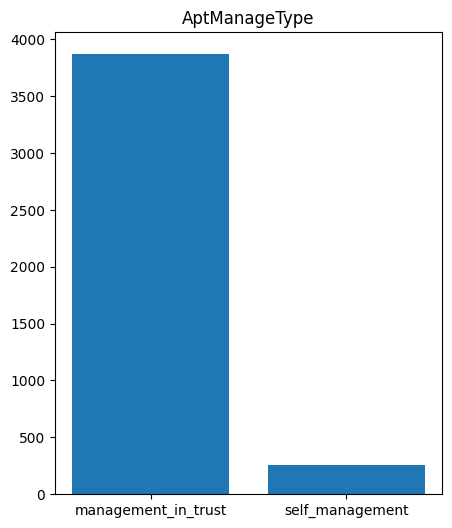

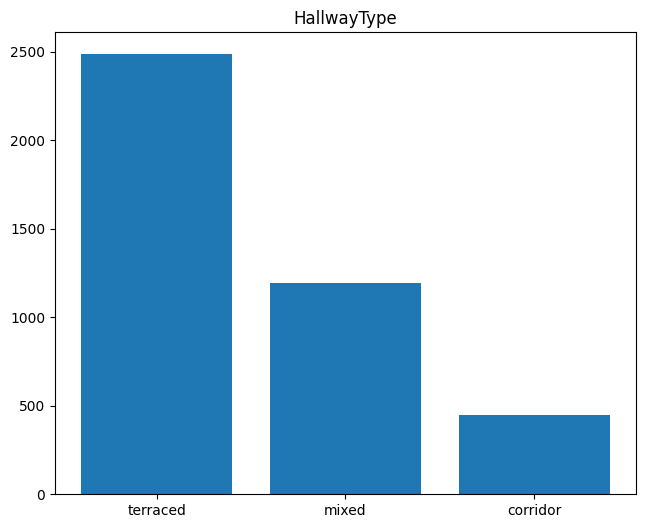

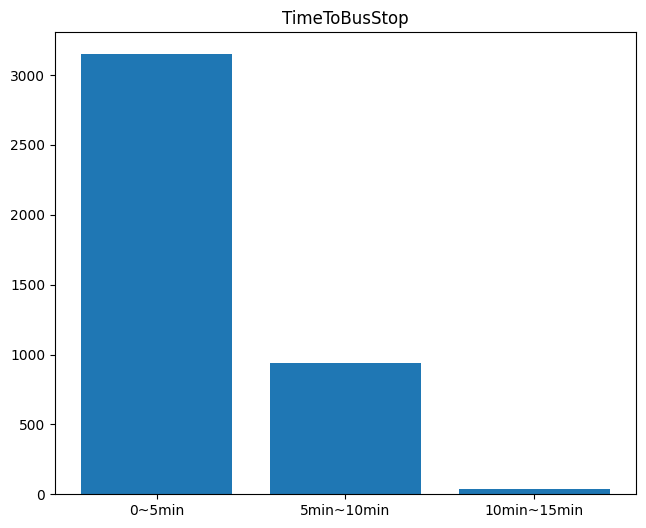

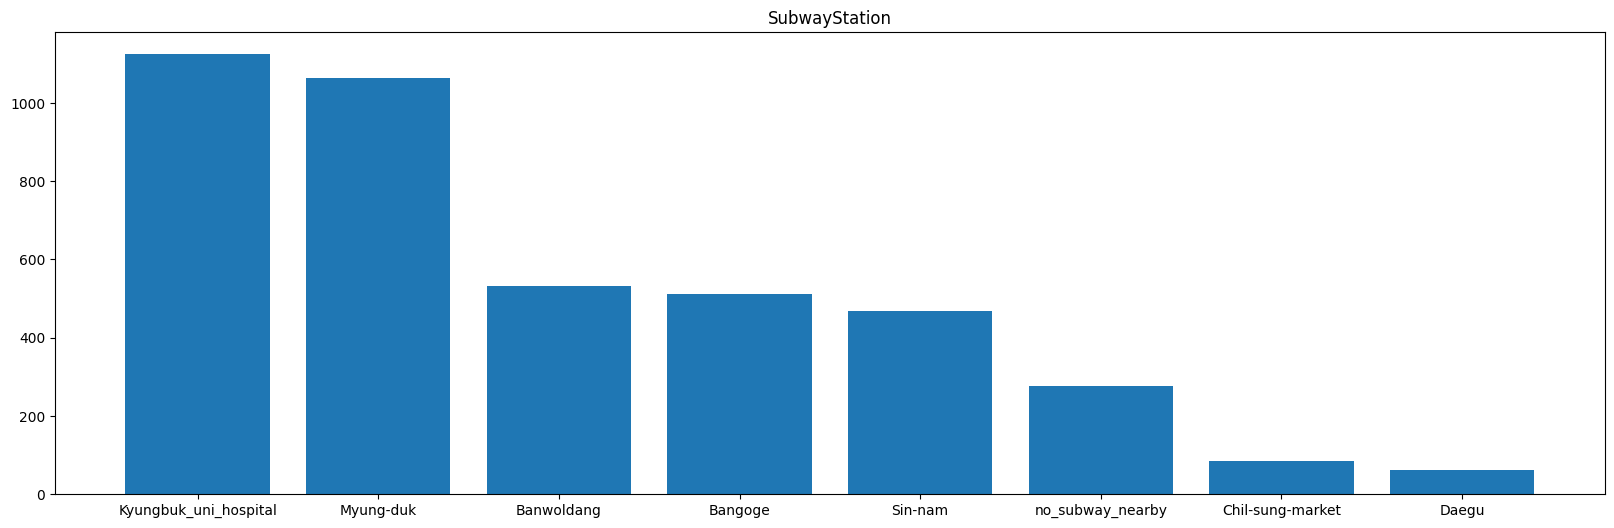

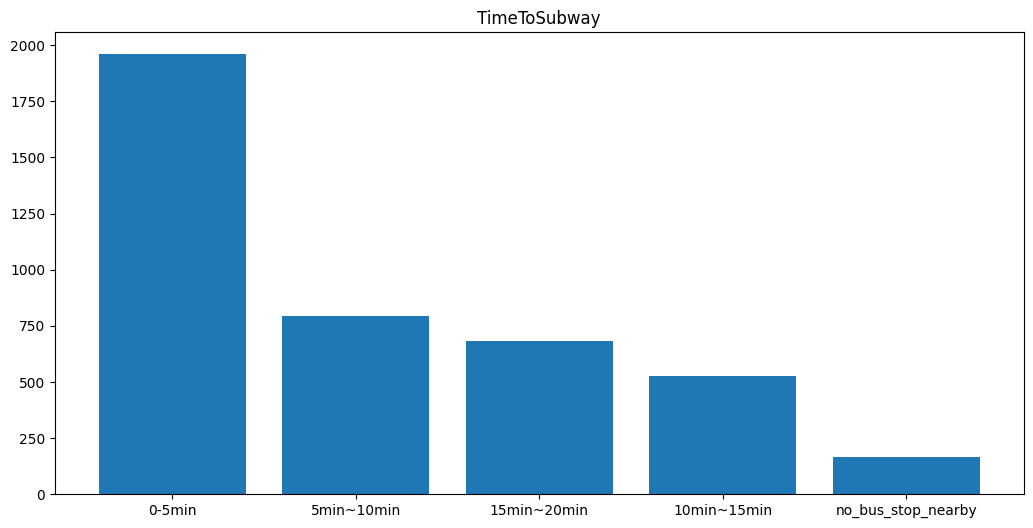

In [16]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

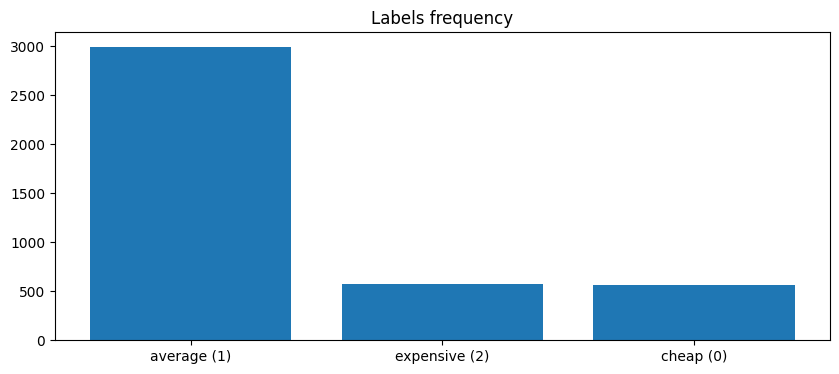

In [17]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

In [18]:
X = df.drop(columns=["Label"])
y = df["Label"]
X, y = preprocessing.preprocess(X, numeric_columns, ordinal_columns, nominal_columns, y=y, oversample=True, undersample=False, random_state=42, echo_ordinal_counts=True)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)

TimeToBusStop value counts:
TimeToBusStop
0~5min         6649
5min~10min     2127
10min~15min     200
Name: count, dtype: int64
ordinal__TimeToBusStop value counts:
ordinal__TimeToBusStop
0.0    6649
1.0    2127
2.0     200
Name: count, dtype: int64
TimeToSubway value counts:
TimeToSubway
0-5min                4160
5min~10min            2064
15min~20min           1349
10min~15min           1238
no_bus_stop_nearby     165
Name: count, dtype: int64
ordinal__TimeToSubway value counts:
ordinal__TimeToSubway
0.0    4160
1.0    2064
3.0    1349
2.0    1238
4.0     165
Name: count, dtype: int64


In [19]:
weights = preprocessing.calculate_class_weights(train_y)
weights

tensor([0.9981, 1.0116, 0.9906])

# Model and training

In [ ]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Epoch: 0, loss: 0.9262816542017777
Epoch: 1, loss: 0.5810232711049308
Epoch: 2, loss: 0.4995629916676378
Epoch: 3, loss: 0.4581893803799047
Epoch: 4, loss: 0.426115712760824
Epoch: 5, loss: 0.4000877726130781
Epoch: 6, loss: 0.38433090406181536
Epoch: 7, loss: 0.3666000222474073
Epoch: 8, loss: 0.35487635077628416
Epoch: 9, loss: 0.34324778168074854
Epoch: 10, loss: 0.33284649450694564
Epoch: 11, loss: 0.3230096072749754
Epoch: 12, loss: 0.322126772947016
Epoch: 13, loss: 0.31587946072088935
Epoch: 14, loss: 0.3134029196426932
Epoch: 15, loss: 0.3116701954761438
Epoch: 16, loss: 0.3081027993322474
Epoch: 17, loss: 0.307384216679936
Epoch: 18, loss: 0.30136689214052353
Epoch: 19, loss: 0.29970370048442774
Epoch: 20, loss: 0.29792326965690713
Epoch: 21, loss: 0.29649663749521815
Epoch: 22, loss: 0.28986508260786004
Epoch: 23, loss: 0.2929889824801842
Epoch: 24, loss: 0.2934908214132343
Epoch: 25, loss: 0.294479387391985
Epoch: 26, loss: 0.2859198391701268
Epoch: 27, loss

In [21]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.900000,0.900000,0.900000,0.900000,0.876392,0.876392,0.876392,0.876392
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.896797,0.896797,0.896797,0.896797,0.877506,0.877506,0.877506,0.877506


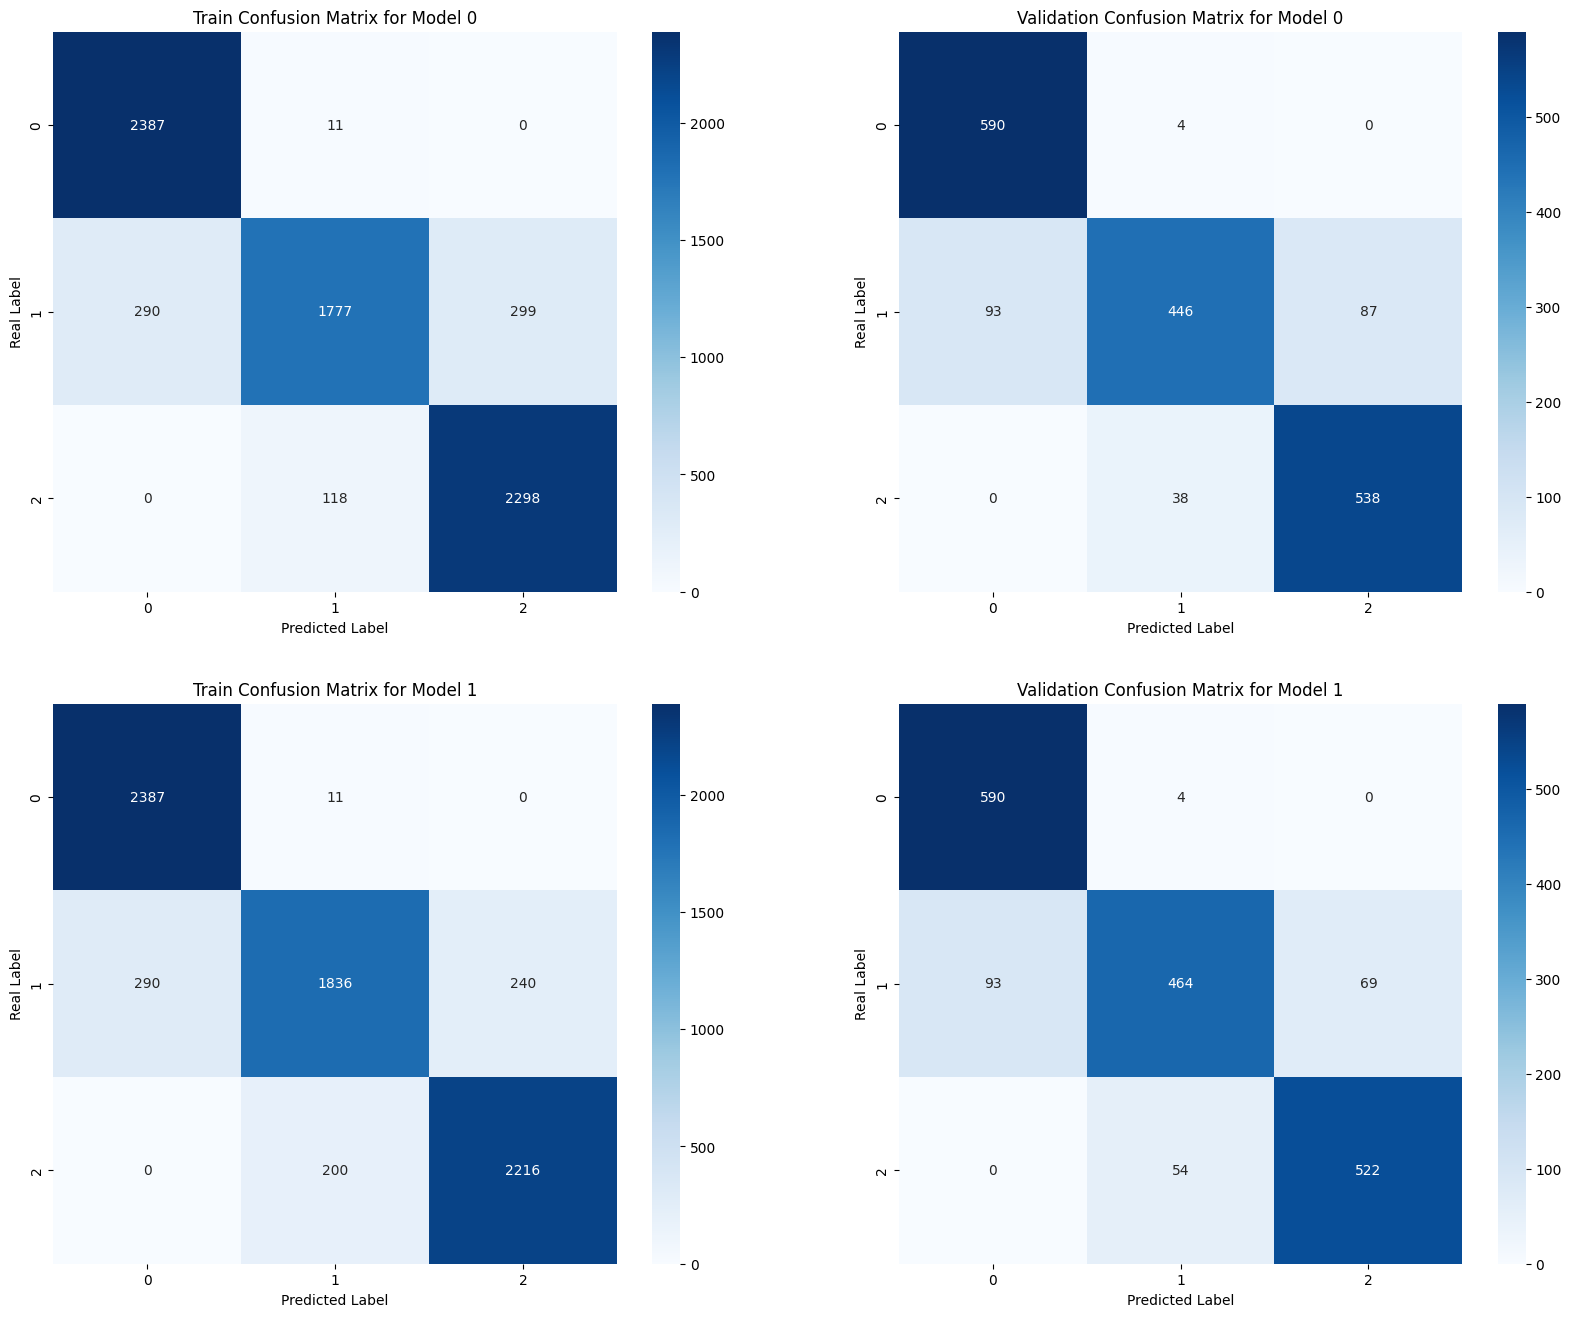

In [22]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

In [ ]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[0], hyperparameters, device)

Training model 0
Epoch: 0, loss: 0.4315480272063112
Epoch: 1, loss: 0.34429491331092027
Epoch: 2, loss: 0.3166112686153007
Epoch: 3, loss: 0.3159373686113189
Epoch: 4, loss: 0.32075980951828237
Epoch: 5, loss: 0.3052543250069154
Epoch: 6, loss: 0.3031217640480109
Epoch: 7, loss: 0.2961472382323932
Epoch: 8, loss: 0.2963324418637605
Epoch: 9, loss: 0.2962508179840788
Epoch: 10, loss: 0.2960452070805879
Epoch: 11, loss: 0.2964260010460837
Epoch: 12, loss: 0.32428190230795767
Epoch: 13, loss: 0.3074658176804011
Epoch: 14, loss: 0.2865724932171602
Epoch: 15, loss: 0.28661339617935955
Epoch: 16, loss: 0.2810630040094916
Epoch: 17, loss: 0.28153149493500196
Epoch: 18, loss: 0.2954610934299705
Epoch: 19, loss: 0.28006002267377567
Epoch: 20, loss: 0.2795074425835525
Epoch: 21, loss: 0.2770231898907012
Epoch: 22, loss: 0.2793172990853808
Epoch: 23, loss: 0.2820461942295058
Epoch: 24, loss: 0.2772176505717556
Epoch: 25, loss: 0.27540062842643365
Epoch: 26, loss: 0.2778811417849718
Epoch: 27, los

KeyboardInterrupt: 

In [ ]:
hyperparameters_results = pd.DataFrame({"models": [architectures[0]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.893454,0.893454,0.893454,0.893454,0.890312,0.890312,0.890312,0.890312
1,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.893036,0.893036,0.893036,0.893036,0.889198,0.889198,0.889198,0.889198
2,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.900279,0.900279,0.900279,0.900279,0.896437,0.896437,0.896437,0.896437
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.897075,0.897075,0.897075,0.897075,0.897550,0.897550,0.897550,0.897550
4,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.897354,0.897354,0.897354,0.897354,0.892539,0.892539,0.892539,0.892539
5,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.891504,0.891504,0.891504,0.891504,0.885857,0.885857,0.885857,0.885857
6,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.868663,0.868663,0.868663,0.868663,0.866927,0.866927,0.866927,0.866927
7,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.825766,0.825766,0.825766,0.825766,0.822940,0.822940,0.822940,0.822940


# Predict on test data

In [ ]:
final_model = train_final_model(train_x, train_y, architectures[0], hyperparameters[5], device)

Training final model
Epoch: 0, loss: 1.1076265625786363
Epoch: 1, loss: 0.7530471567522016
Epoch: 2, loss: 0.6214402506225988
Epoch: 3, loss: 0.558507057658413
Epoch: 4, loss: 0.5179325404920077
Epoch: 5, loss: 0.48692377878908527
Epoch: 6, loss: 0.46475393834866974
Epoch: 7, loss: 0.43998720300825017
Epoch: 8, loss: 0.42261704488804464
Epoch: 9, loss: 0.40904017916896884
Epoch: 10, loss: 0.40322236324611466
Epoch: 11, loss: 0.38526964396761176
Epoch: 12, loss: 0.3794501792443426
Epoch: 13, loss: 0.35947086675125256
Epoch: 14, loss: 0.35152006776709305
Epoch: 15, loss: 0.3463440286485772
Epoch: 16, loss: 0.34378917645989804
Epoch: 17, loss: 0.33453138564762314
Epoch: 18, loss: 0.33366212091947856
Epoch: 19, loss: 0.3229791495883674
Epoch: 20, loss: 0.31717036455346825
Epoch: 21, loss: 0.31703190897640426
Epoch: 22, loss: 0.3151839830373463
Epoch: 23, loss: 0.3127055013911766
Epoch: 24, loss: 0.30993115535953586
Epoch: 25, loss: 0.3051711488188359
Epoch: 26, loss: 0.3092954843713526
Epo

In [ ]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns, y=pd.Series(), oversample=False, undersample=False, random_state=42, echo_ordinal_counts=False)

In [ ]:
test_preds = predict(final_model, test_x)
np.savetxt("preds.csv", test_preds, delimiter=",", fmt='%d')

# Conclusions